# VAE Modeling

In [19]:
import torch
import numpy as np
from utils.dataload import prepare_data_loaders, set_seed
from utils.functions import load_best_params, pca, train_vae, save_model, load_model, display_spectrums, vae_reconstruction, vae_latent_3d, vae_latent_2d, vae_latent_interpolation, print_top_latent_std
import numpy as np
from VAE.vae import VAE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
print(torch.cuda.is_available())        # True
print(torch.cuda.get_device_name(0))    # Nom du GPU
set_seed(42) 

True
NVIDIA T400 4GB


## VAE Training

In [161]:
# Chargement des meilleurs paramètres
# ============================================================
latent_dim, hidden_dim_list, lr, dropout = load_best_params(json_path="best_params.json")

Best parameters found:
Latent dimension: 20
Hidden dimensions: [1024, 512, 256, 128]
Learning rate: 0.001
Dropout rate: 0


Data loaded and normalized. Returning dataset.
Train dataset size: 2872
Test dataset size: 718
X_batch shape: torch.Size([64, 4])
y_batch shape: torch.Size([64, 5000])


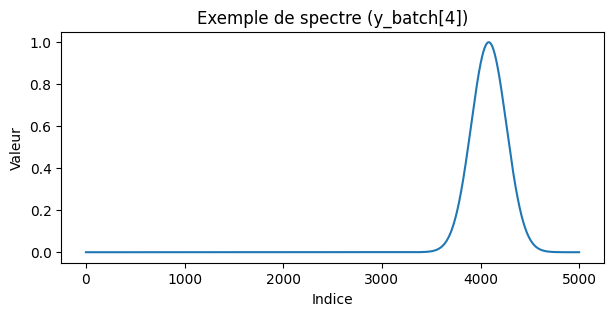

dim_x: 4
dim_y: 5000
Input dimension: 5004
Using device: cuda


In [162]:
# Data loading and preparation
# ============================================================
dataloader_train, dataloader_test, dataset, train_dataset, test_dataset, scaler_x, dim_x, dim_y, input_dim, device = prepare_data_loaders(batch_size=64, test_ratio=0.2, plot_example=True, seed=42)

In [26]:
# Analyse PCA
# ============================================================
pca(dataset)

Shape of concatenated data (X, Y): (3590, 5004)
Nombre de composantes pour 99% de variance : 20


Epoch 1/1000, Train Loss: 0.0560, Val Loss: 0.0553
Epoch 2/1000, Train Loss: 0.0554, Val Loss: 0.0553
Epoch 3/1000, Train Loss: 0.0553, Val Loss: 0.0553
Epoch 4/1000, Train Loss: 0.0553, Val Loss: 0.0552
Epoch 5/1000, Train Loss: 0.0553, Val Loss: 0.0553
Epoch 6/1000, Train Loss: 0.0553, Val Loss: 0.0552
Epoch 7/1000, Train Loss: 0.0553, Val Loss: 0.0552
Epoch 8/1000, Train Loss: 0.0553, Val Loss: 0.0550
Epoch 9/1000, Train Loss: 0.0539, Val Loss: 0.0522
Epoch 10/1000, Train Loss: 0.0522, Val Loss: 0.0516
Epoch 11/1000, Train Loss: 0.0516, Val Loss: 0.0502
Epoch 12/1000, Train Loss: 0.0499, Val Loss: 0.0484
Epoch 13/1000, Train Loss: 0.0476, Val Loss: 0.0456
Epoch 14/1000, Train Loss: 0.0461, Val Loss: 0.0449
Epoch 15/1000, Train Loss: 0.0446, Val Loss: 0.0430
Epoch 16/1000, Train Loss: 0.0428, Val Loss: 0.0427
Epoch 17/1000, Train Loss: 0.0416, Val Loss: 0.0410
Epoch 18/1000, Train Loss: 0.0407, Val Loss: 0.0411
Epoch 19/1000, Train Loss: 0.0397, Val Loss: 0.0404
Epoch 20/1000, Train 

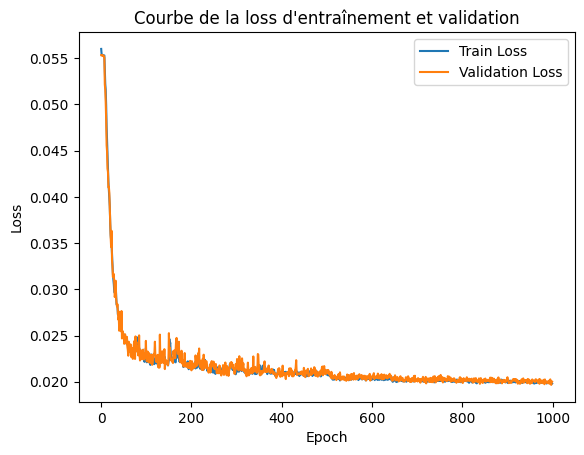

In [164]:
# Initialisation du modèle et de l'optimiseur
# ============================================================
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim_list=hidden_dim_list, dropout=dropout, beta=0.1).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-6)

num_epochs = 1000

train_vae(vae, optimizer, scheduler, num_epochs, dataloader_train, dataloader_test, device)


In [165]:
# Sauvegarde du modèle entraîné
# ============================================================
model_path = "saved_models/vae_trained_20_0.1.pth"
save_model(vae, optimizer, model_path, input_dim, latent_dim, hidden_dim_list, dropout, scaler_x)

Modèle sauvegardé sous saved_models/vae_trained_20_0.1.pth


# Chargement du modèle

In [166]:
# Chargement du modèle entraîné
# ============================================================
model_path = "saved_models/vae_trained_20_0.1.pth"
vae, optimizer_state_dict, scaler_x, device = load_model(model_path)

Paramètres du modèle chargés :
Input dimension: 5004
Latent dimension: 20
Hidden dimensions: [1024, 512, 256, 128]
Dropout rate: 0
Modèle chargé avec succès.


recon_x shape: (64, 4)
recon_y shape: (64, 5000)
X normalisé: [-0.16616139 -0.12940094 -0.07942156  0.08766581]
Y normalisé: [0.00110945 0.00111863 0.00135652 ... 0.00479119 0.00458768 0.00539558]
orig_x shape: (64, 4)
orig_y shape: (64, 5000)
X normalisé: [ 1.5179088   1.0631685   0.04484    -0.63595027]
Y normalisé: [3.8423274e-05 3.8677332e-05 3.8930630e-05 ... 2.3197284e-05 2.3365181e-05
 0.0000000e+00]


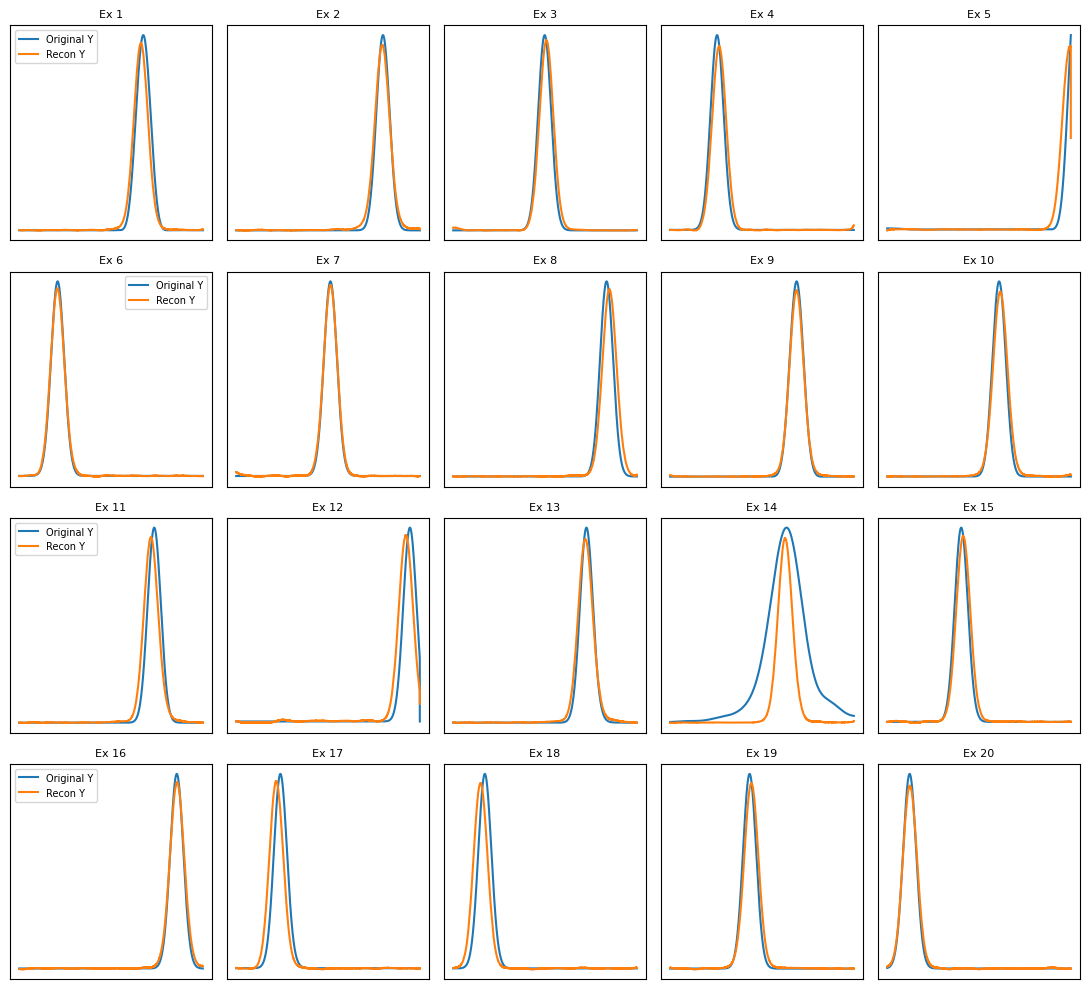

In [167]:
# Reconstruction des données de test
# ============================================================
orig_x, orig_y, recon_x, recon_y = vae_reconstruction(vae, dataloader_test, device, dim_x)

n_examples = 20
display_spectrums(n_examples, orig_y, recon_y)

In [168]:
# Visualisation des composantes latentes actives
# ============================================================
z_list = []
vae.eval()
with torch.no_grad():
    for x_batch, y_batch in dataloader_train:
        xy_batch = torch.cat([x_batch, y_batch], dim=1).to(device)
        mu, logvar = vae.encode(xy_batch)
        z_list.append(mu.cpu())  # stocke les mu (sans reparam.)
# Concatène tous les z en un seul tensor
z_train = torch.cat(z_list, dim=0)  # shape [N, latent_dim]

print("Shape of z_train:", z_train.shape)
std = z_train.std(dim=0)
top3_indices = print_top_latent_std(std, top_n=3)


Shape of z_train: torch.Size([2872, 20])
Std of z_train (sorted):
z[8] : 0.9966
z[12] : 0.0023
z[1] : 0.0022
z[14] : 0.0022
z[0] : 0.0020
z[17] : 0.0020
z[15] : 0.0020
z[3] : 0.0020
z[19] : 0.0020
z[11] : 0.0019
z[5] : 0.0019
z[10] : 0.0019
z[6] : 0.0018
z[18] : 0.0018
z[2] : 0.0017
z[13] : 0.0016
z[9] : 0.0016
z[7] : 0.0016
z[4] : 0.0015
z[16] : 0.0013

Indices des 3 plus grandes std : [ 8 12  1]


In [169]:
# Visualisation 3D des données dans l'espace latent
# ============================================================
dataloader_test_big = DataLoader(test_dataset, batch_size=1024, shuffle=False)

index1, index2, index3 = top3_indices[0], top3_indices[1], top3_indices[2]
vae_latent_3d(vae, dataloader_test_big, index1=index1, index2=index2, index3=index3, color_mode="peak_pos", device=device)

X_batch shape: torch.Size([718, 4])
y_batch shape: torch.Size([718, 5000])


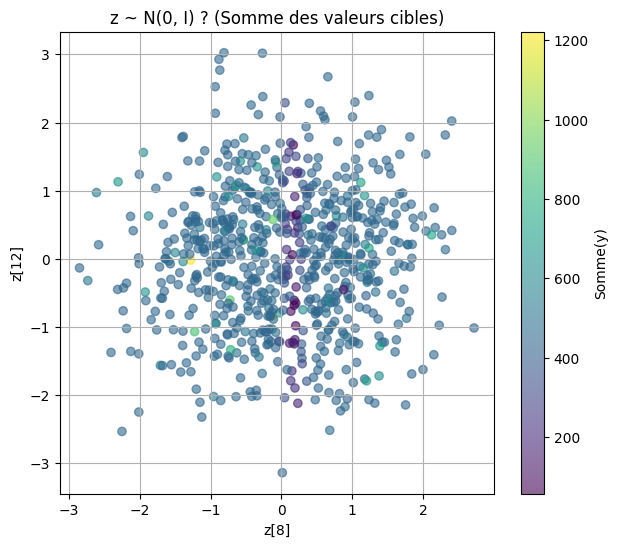

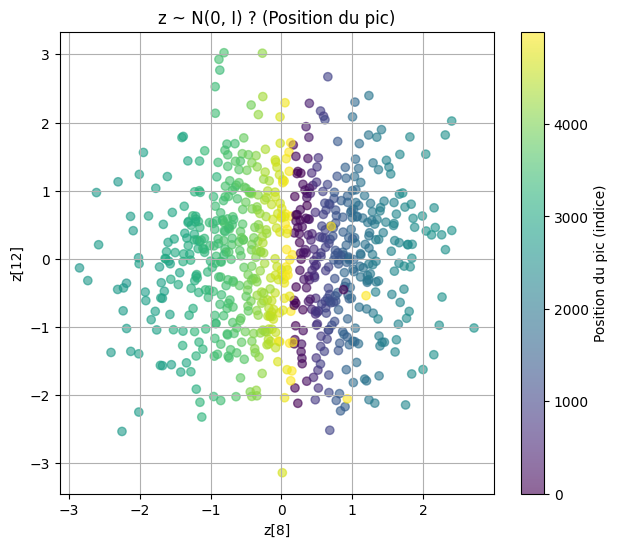

Variance moyenne de z : 1.0120594501495361
Moyenne de z : [ 0.00366663 -0.03086395 -0.00236151  0.04657601 -0.0216047   0.08324578
  0.02719437  0.01037276  0.02817911  0.00053041  0.04009872  0.00546846
  0.00090616  0.0141269   0.01806882  0.00232453 -0.01656858  0.03102546
  0.0287632   0.01357962]


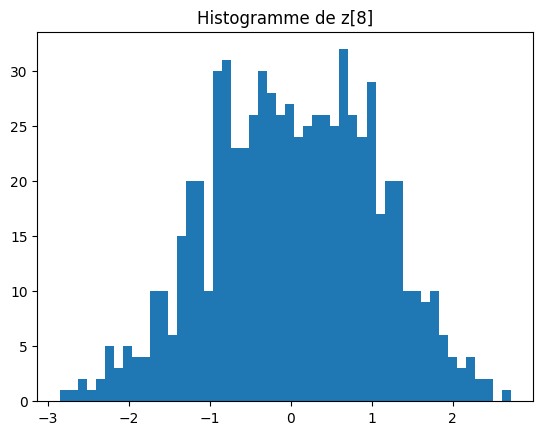

In [171]:
# Visualisation 2D des données dans l'espace latent
# ============================================================
vae_latent_2d(vae, dataloader_test_big, index_x=index1, index_y=index2, index_histo=8, device=None)

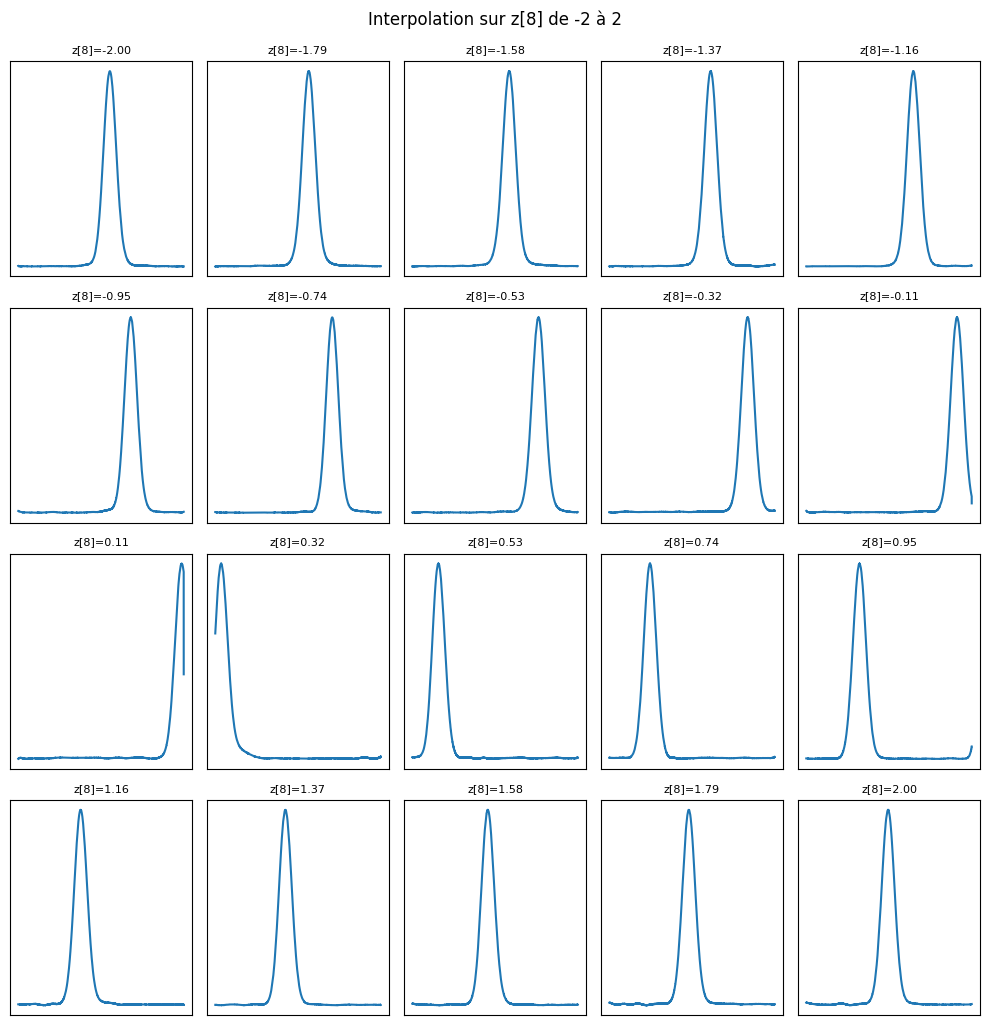

In [172]:
# Interpolation dans l'espace latent
# ============================================================
axis = index1
steps = 20
vae_latent_interpolation(vae, latent_dim=latent_dim, dim_x=4, axis=axis, z_min=-2, z_max=2, steps=steps, fixed_z=None, device=None)

In [173]:
# Inverse de la standardisation
recon_x_orig = scaler_x.inverse_transform(recon_x)
orig_x_orig = scaler_x.inverse_transform(orig_x)

# ============================================================
# Affichage d'exemples (ici on affiche la première donnée du batch)
# ============================================================
index = 0

print("=== Données originales ===")
print("X:", orig_x_orig[index])
print("Y:", orig_y[index])

print("\n=== Reconstruction ===")
print("X reconstruit:", recon_x_orig[index])
print("Y reconstruit:", recon_y[index])


=== Données originales ===
X: [5.9300000e+02 8.0000001e-01 4.3100000e+02 4.5192285e+06]
Y: [3.8423274e-05 3.8677332e-05 3.8930630e-05 ... 2.3197284e-05 2.3365181e-05
 0.0000000e+00]

=== Reconstruction ===
X reconstruit: [3.9824399e+02 5.4239666e-01 4.1516080e+02 5.8051225e+06]
Y reconstruit: [0.00110945 0.00111863 0.00135652 ... 0.00479119 0.00458768 0.00539558]


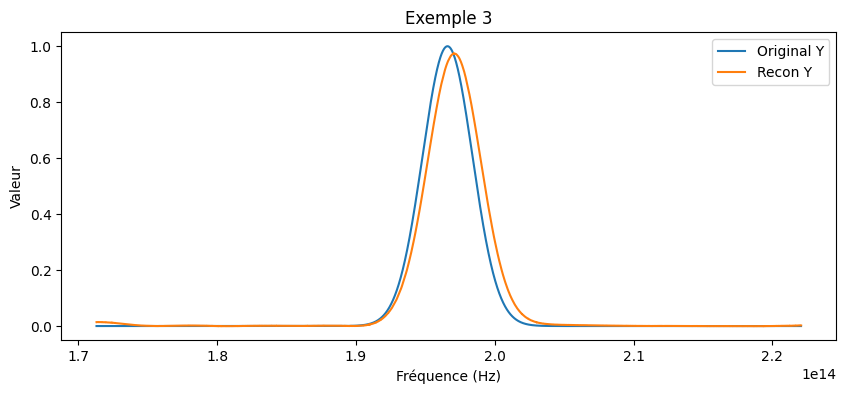

In [174]:
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

i = 2  # Choisis l'index de la courbe à afficher

plt.figure(figsize=(10, 4))
plt.plot(frequencies, orig_y[i], label='Original Y')
plt.plot(frequencies, recon_y[i], label='Recon Y')
plt.title(f"Exemple {i+1}", fontsize=12)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Valeur")
plt.legend()
plt.show()

          Donnée x ∈ ℝ⁵⁰⁰⁴
                │
           +----▼----+
           | encodeur|
           +----+----+
                │
     ┌──────────┴────────────┐
     ↓                       ↓
 mu ∈ ℝⁿˣ³²           logvar ∈ ℝⁿˣ³²
     │                       │
     └─────┬────────────┬────┘
           ↓            ↓
    std = exp(0.5*logvar)
           ↓
   z = mu + eps * std  → ℝⁿˣ³²
           ↓
     décodeur(z) → x̂ ∈ ℝⁿˣ⁵⁰⁰⁴


# Génération synthétique

In [175]:
mean = z_train.mean(dim=0)  # centre
std = z_train.std(dim=0)    # écart-type par dimension
print("Mean of z_train:", mean)
print("Std of z_train:", std) 
  
# Optionnel : matrice de covariance
cov = torch.cov(z_train.T)  # shape (latent_dim, latent_dim)
mean = mean.to(device)
std = std.to(device)
cov = cov.to(device)

Mean of z_train: tensor([ 1.5089e-03,  1.3248e-03, -6.6800e-05,  1.1909e-03, -2.7658e-04,
         5.6139e-04,  7.2822e-04, -8.7128e-04, -5.2317e-03, -2.5060e-04,
         1.8640e-04, -1.0324e-03,  8.3863e-04, -1.0266e-03, -1.6555e-04,
        -4.1191e-04, -1.2853e-03, -2.5955e-04,  4.2123e-04, -1.6182e-03])
Std of z_train: tensor([0.0020, 0.0022, 0.0017, 0.0020, 0.0015, 0.0019, 0.0018, 0.0016, 0.9966,
        0.0016, 0.0019, 0.0019, 0.0023, 0.0016, 0.0022, 0.0020, 0.0013, 0.0020,
        0.0018, 0.0020])


In [176]:
from torch.distributions import MultivariateNormal

n_samples = 1000  # Nombre d'échantillons à générer
mvn = MultivariateNormal(mean, covariance_matrix=cov)
z = mvn.sample((n_samples,)).to(device)

# Filtrage des z trop improbables (garde les 99% les plus probables)
log_probs = mvn.log_prob(z)
threshold = torch.quantile(log_probs, 0.01)  # Garde les 99% les plus probables
mask = log_probs > threshold
z_filtered = z[mask]

print(f"Nombre de z gardés après filtrage : {z_filtered.shape[0]}")

# Générer les données avec le décodeur à partir des z filtrés
with torch.no_grad():
    generated = vae.decode(z_filtered)  # [n_samples_filtrés, input_dim]

    # Séparer X et Y générés
    generated = generated.cpu().numpy()
    gen_x = generated[:, :dim_x]
    gen_y = generated[:, dim_x:]

# Dénormaliser si besoin
gen_x_orig = scaler_x.inverse_transform(gen_x)

print("Shape X généré :", gen_x_orig.shape)
print("Shape Y généré :", gen_y.shape)

Nombre de z gardés après filtrage : 990
Shape X généré : (990, 4)
Shape Y généré : (990, 5000)


C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\gabriel.legros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



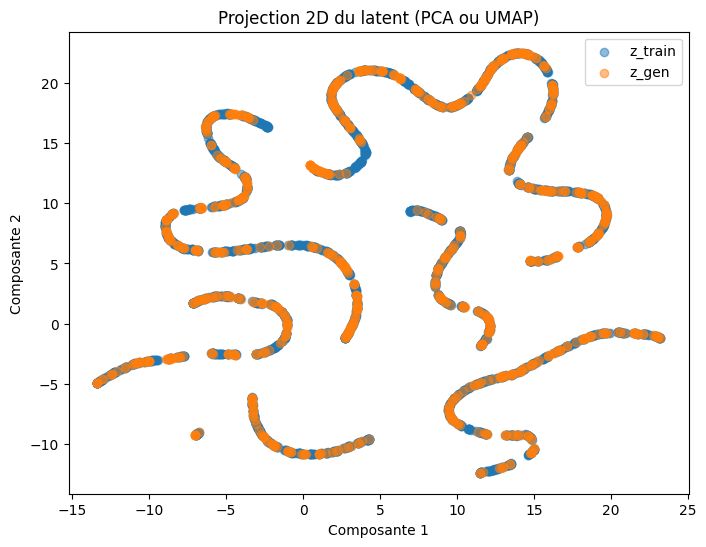

In [177]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# z_train : shape [N, latent_dim]
# z_gen : shape [M, latent_dim] (par exemple z_filtered ou z)

z_train_np = z_train.cpu().numpy()
z_gen_np = z_filtered.cpu().numpy()  # ou z.cpu().numpy() selon ce que tu veux comparer

X = np.concatenate([z_train_np, z_gen_np], axis=0)
labels = np.array(['train'] * len(z_train_np) + ['gen'] * len(z_gen_np))

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

import umap
X_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[labels=='train',0], X_2d[labels=='train',1], alpha=0.5, label='z_train')
plt.scatter(X_2d[labels=='gen',0], X_2d[labels=='gen',1], alpha=0.5, label='z_gen')
plt.legend()
plt.title("Projection 2D du latent (PCA ou UMAP)")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

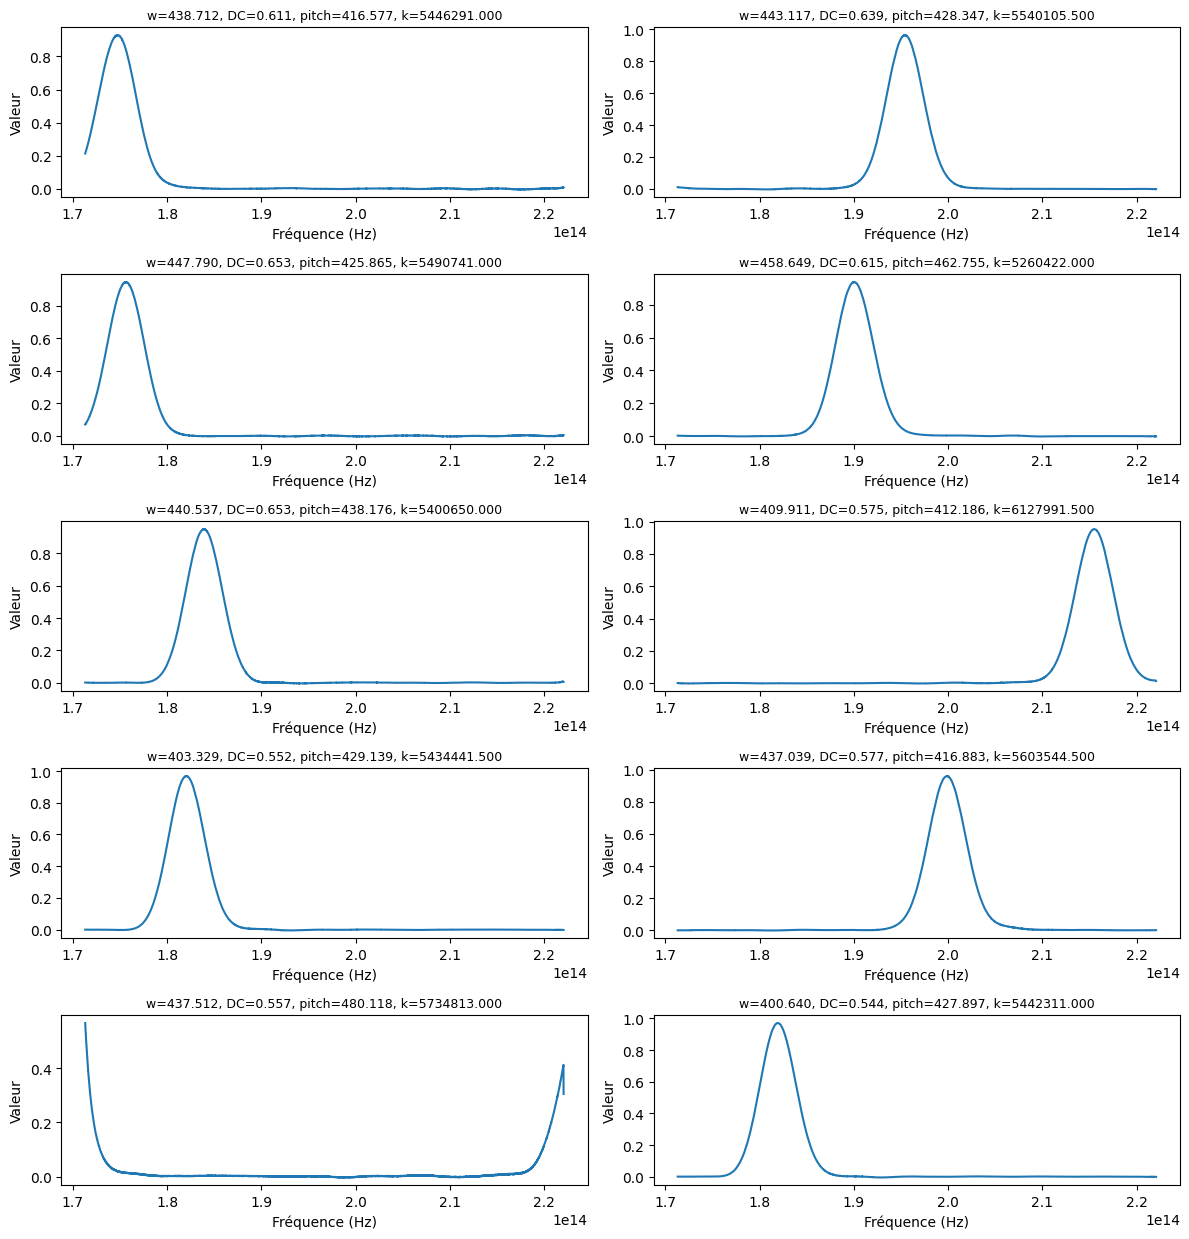

In [178]:
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

# Sélectionne 10 indices aléatoires dans les données générées
n_plot = 10
indices = np.random.choice(gen_y.shape[0], n_plot, replace=False)

n_cols = 2
n_rows = n_plot // n_cols

plt.figure(figsize=(12, 2.5 * n_rows))
for idx, i in enumerate(indices):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.plot(frequencies, gen_y[i], label='Spectre généré')
    w, DC, pitch, k = gen_x_orig[i, 0], gen_x_orig[i, 1], gen_x_orig[i, 2], gen_x_orig[i, 3]
    plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f}", fontsize=9)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.tight_layout()
plt.show()

In [179]:
def count_peaks(spectre, threshold=0.1):
    above = spectre >= threshold
    # Un pic commence quand on passe de False à True
    return np.sum((~above[:-1]) & (above[1:]))

# On ajoute le cas où le tout premier point est déjà un pic
def count_peaks_full(spectre, threshold=0.1):
    above = spectre >= threshold
    # Pic au début si le premier point est au-dessus du seuil
    count = int(above[0])
    count += np.sum((~above[:-1]) & (above[1:]))
    return count

# Appliquer à tous les spectres générés
peaks_per_spectre = np.array([count_peaks_full(s, threshold=0.1) for s in gen_y])

# Statistiques
unique, counts_unique = np.unique(peaks_per_spectre, return_counts=True)
print("Répartition du nombre de pics par spectre généré :")
for u, c in zip(unique, counts_unique):
    print(f"{u} pics : {c} spectres")

Répartition du nombre de pics par spectre généré :
1 pics : 963 spectres
2 pics : 27 spectres


In [180]:
# Sélectionner uniquement les spectres générés avec 1 pic

# peaks_per_spectre a été calculé précédemment
mask_1pic = (peaks_per_spectre == 1)
gen_x_1pic = gen_x_orig[mask_1pic]
gen_y_1pic = gen_y[mask_1pic]

print("Nombre de spectres générés avec 1 pic :", gen_x_1pic.shape[0])
print("Shape X généré avec 1 pic :", gen_x_1pic.shape)
print("Shape Y généré avec 1 pic :", gen_y_1pic.shape)

Nombre de spectres générés avec 1 pic : 963
Shape X généré avec 1 pic : (963, 4)
Shape Y généré avec 1 pic : (963, 5000)


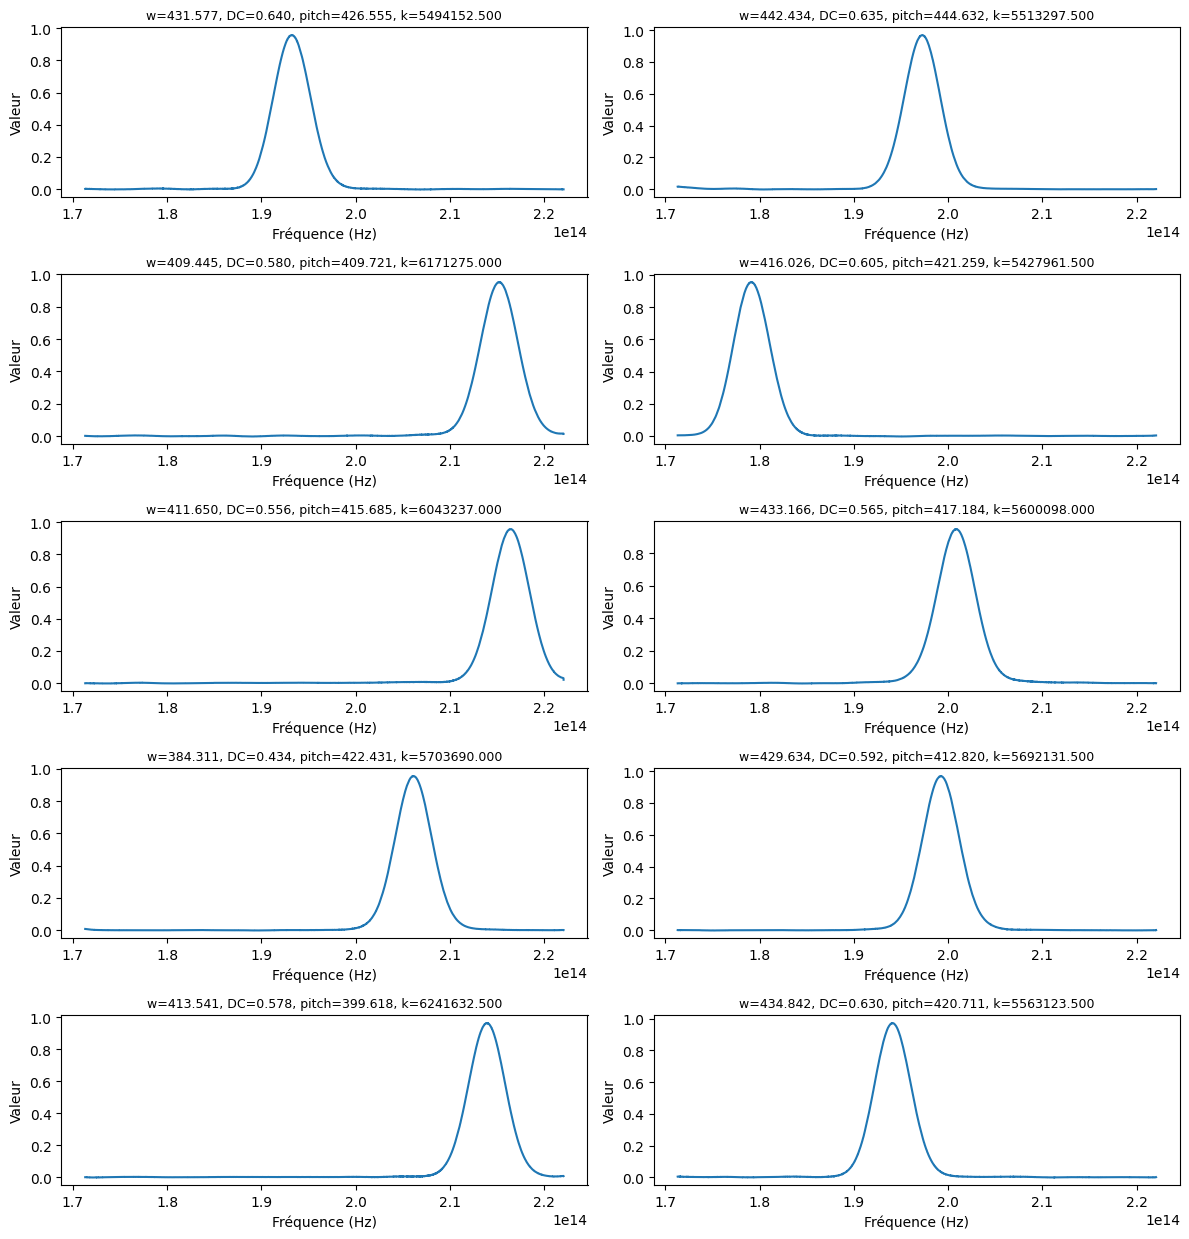

In [181]:
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

# Sélectionne 10 indices aléatoires dans les données générées
n_plot = 10
indices = np.random.choice(gen_y_1pic.shape[0], n_plot, replace=False)

n_cols = 2
n_rows = n_plot // n_cols

plt.figure(figsize=(12, 2.5 * n_rows))
for idx, i in enumerate(indices):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.plot(frequencies, gen_y_1pic[i], label='Spectre généré')
    w, DC, pitch, k = gen_x_1pic[i, 0], gen_x_1pic[i, 1], gen_x_1pic[i, 2], gen_x_1pic[i, 3]
    plt.title(f"w={w:.3f}, DC={DC:.3f}, pitch={pitch:.3f}, k={k:.3f}", fontsize=9)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.tight_layout()
plt.show()

### Data augmentation

Shape de x_data : (3590, 4)
Shape de y_data après normalisation : (3590, 5000)


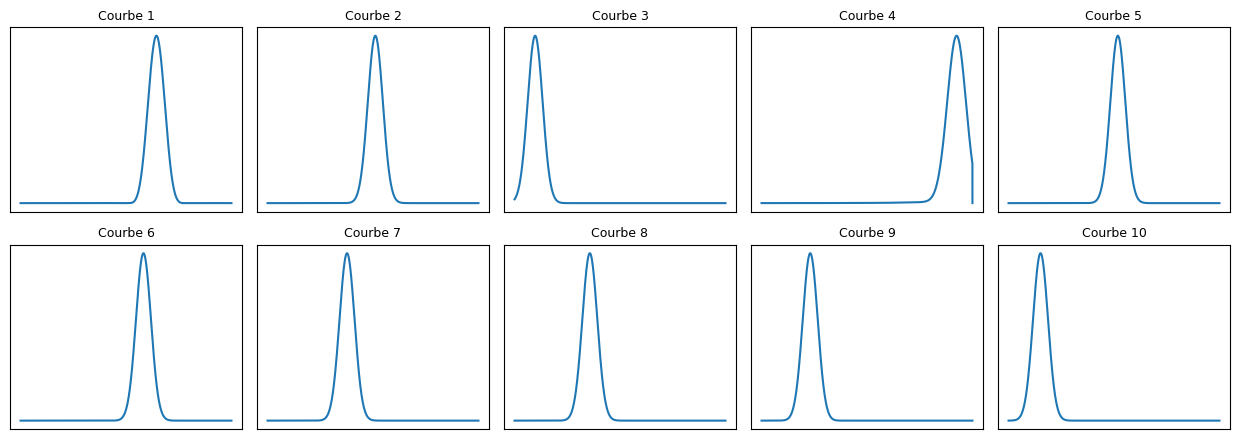

In [126]:
# Chargement des données
x_data = np.load('data/X_data_array_5000.npy')
y_data = np.load('data/y_data_array_5000.npy')

# Réduction de Y : on prend 1 point sur 10 (axis=1)
#y_data = y_data[:, ::10]  # (n, 500)

# --- Normalisation au pic pour chaque spectre ---
y_max = np.max(y_data, axis=1, keepdims=True)
y_max[y_max == 0] = 1  # éviter division par zéro
y_data = y_data / y_max

print("Shape de x_data :", x_data.shape)
print("Shape de y_data après normalisation :", y_data.shape)

# Affichage des 30 premières courbes, une par subplot
n_examples = 10
n_cols = 5
n_rows = 6

plt.figure(figsize=(2.5*n_cols, 2.2*n_rows))
for i in range(n_examples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(np.arange(1, 5001), y_data[i])
    plt.title(f"Courbe {i+1}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [127]:
x_data_aug = np.concatenate([x_data, gen_x_1pic], axis=0)
y_data_aug = np.concatenate([y_data, gen_y_1pic], axis=0)

from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
x_data_aug = scaler_x.fit_transform(x_data_aug)

print("Nouvelle taille de x_data :", x_data_aug.shape)
print("Nouvelle taille de y_data :", y_data_aug.shape)
print("Moyenne de x_data :", x_data_aug.mean(axis=0))
print("Écart-type de x_data :", x_data_aug.std(axis=0))

Nouvelle taille de x_data : (7309, 4)
Nouvelle taille de y_data : (7309, 5000)
Moyenne de x_data : [ 1.8708552e-06  2.7773569e-07 -2.7663989e-07  1.3827865e-07]
Écart-type de x_data : [1.0000011 0.9999965 1.0000007 0.9999988]


# FNN Training

In [112]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from FNN.feedforwardNN import FeedforwardNN

In [129]:
# Hyperparamètres
input_dim = 4
output_dim = 5000
hidden_dim_list = [955, 925, 1005, 407, 580, 1309]
dropout = 0.01
lr = 1.6e-3
batch_size = 128
num_epochs = 1000

In [131]:
# Préparation des données
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

x_tensor = torch.tensor(x_data_aug, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_data_aug, dtype=torch.float32).to(device)
dataset = TensorDataset(x_tensor, y_tensor)
# Split train/val (par exemple 80/20)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset)) 
print("Exemple de batch :")
data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)
print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)


Using device: cuda
Train dataset size: 5848
Validation dataset size: 1461
Exemple de batch :
X_batch shape: torch.Size([128, 4])
y_batch shape: torch.Size([128, 5000])


Epoch 1/1000 - Train Loss: 0.0568 - Val Loss: 0.0518
Epoch 2/1000 - Train Loss: 0.0493 - Val Loss: 0.0454
Epoch 3/1000 - Train Loss: 0.0403 - Val Loss: 0.0344
Epoch 4/1000 - Train Loss: 0.0324 - Val Loss: 0.0294
Epoch 5/1000 - Train Loss: 0.0265 - Val Loss: 0.0260
Epoch 6/1000 - Train Loss: 0.0224 - Val Loss: 0.0199
Epoch 7/1000 - Train Loss: 0.0181 - Val Loss: 0.0144
Epoch 8/1000 - Train Loss: 0.0162 - Val Loss: 0.0137
Epoch 9/1000 - Train Loss: 0.0150 - Val Loss: 0.0124
Epoch 10/1000 - Train Loss: 0.0122 - Val Loss: 0.0110
Epoch 11/1000 - Train Loss: 0.0117 - Val Loss: 0.0123
Epoch 12/1000 - Train Loss: 0.0110 - Val Loss: 0.0091
Epoch 13/1000 - Train Loss: 0.0117 - Val Loss: 0.0083
Epoch 14/1000 - Train Loss: 0.0107 - Val Loss: 0.0089
Epoch 15/1000 - Train Loss: 0.0094 - Val Loss: 0.0078
Epoch 16/1000 - Train Loss: 0.0090 - Val Loss: 0.0071
Epoch 17/1000 - Train Loss: 0.0084 - Val Loss: 0.0070
Epoch 18/1000 - Train Loss: 0.0088 - Val Loss: 0.0067
Epoch 19/1000 - Train Loss: 0.0081 - 

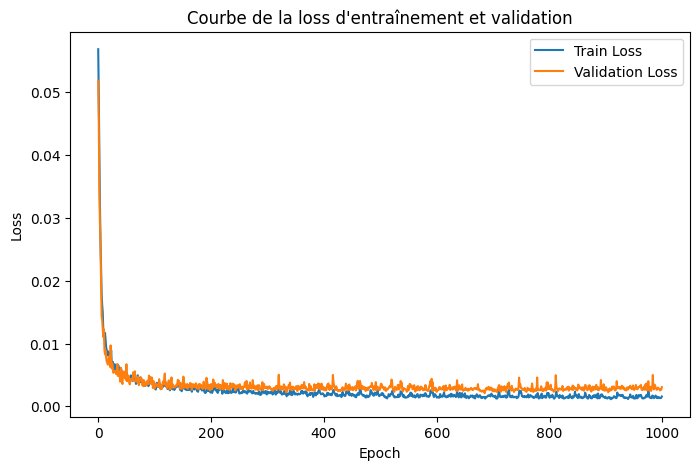

In [ ]:
# Modèle
model = FeedforwardNN(input_dim, output_dim, hidden_dim_list, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

train_losses = []
val_losses = []

# Entraînement
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # <-- passage sur CUDA
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)  # <-- passage sur CUDA
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# Affichage des courbes de loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la loss d'entraînement et validation")
plt.legend()
plt.show()

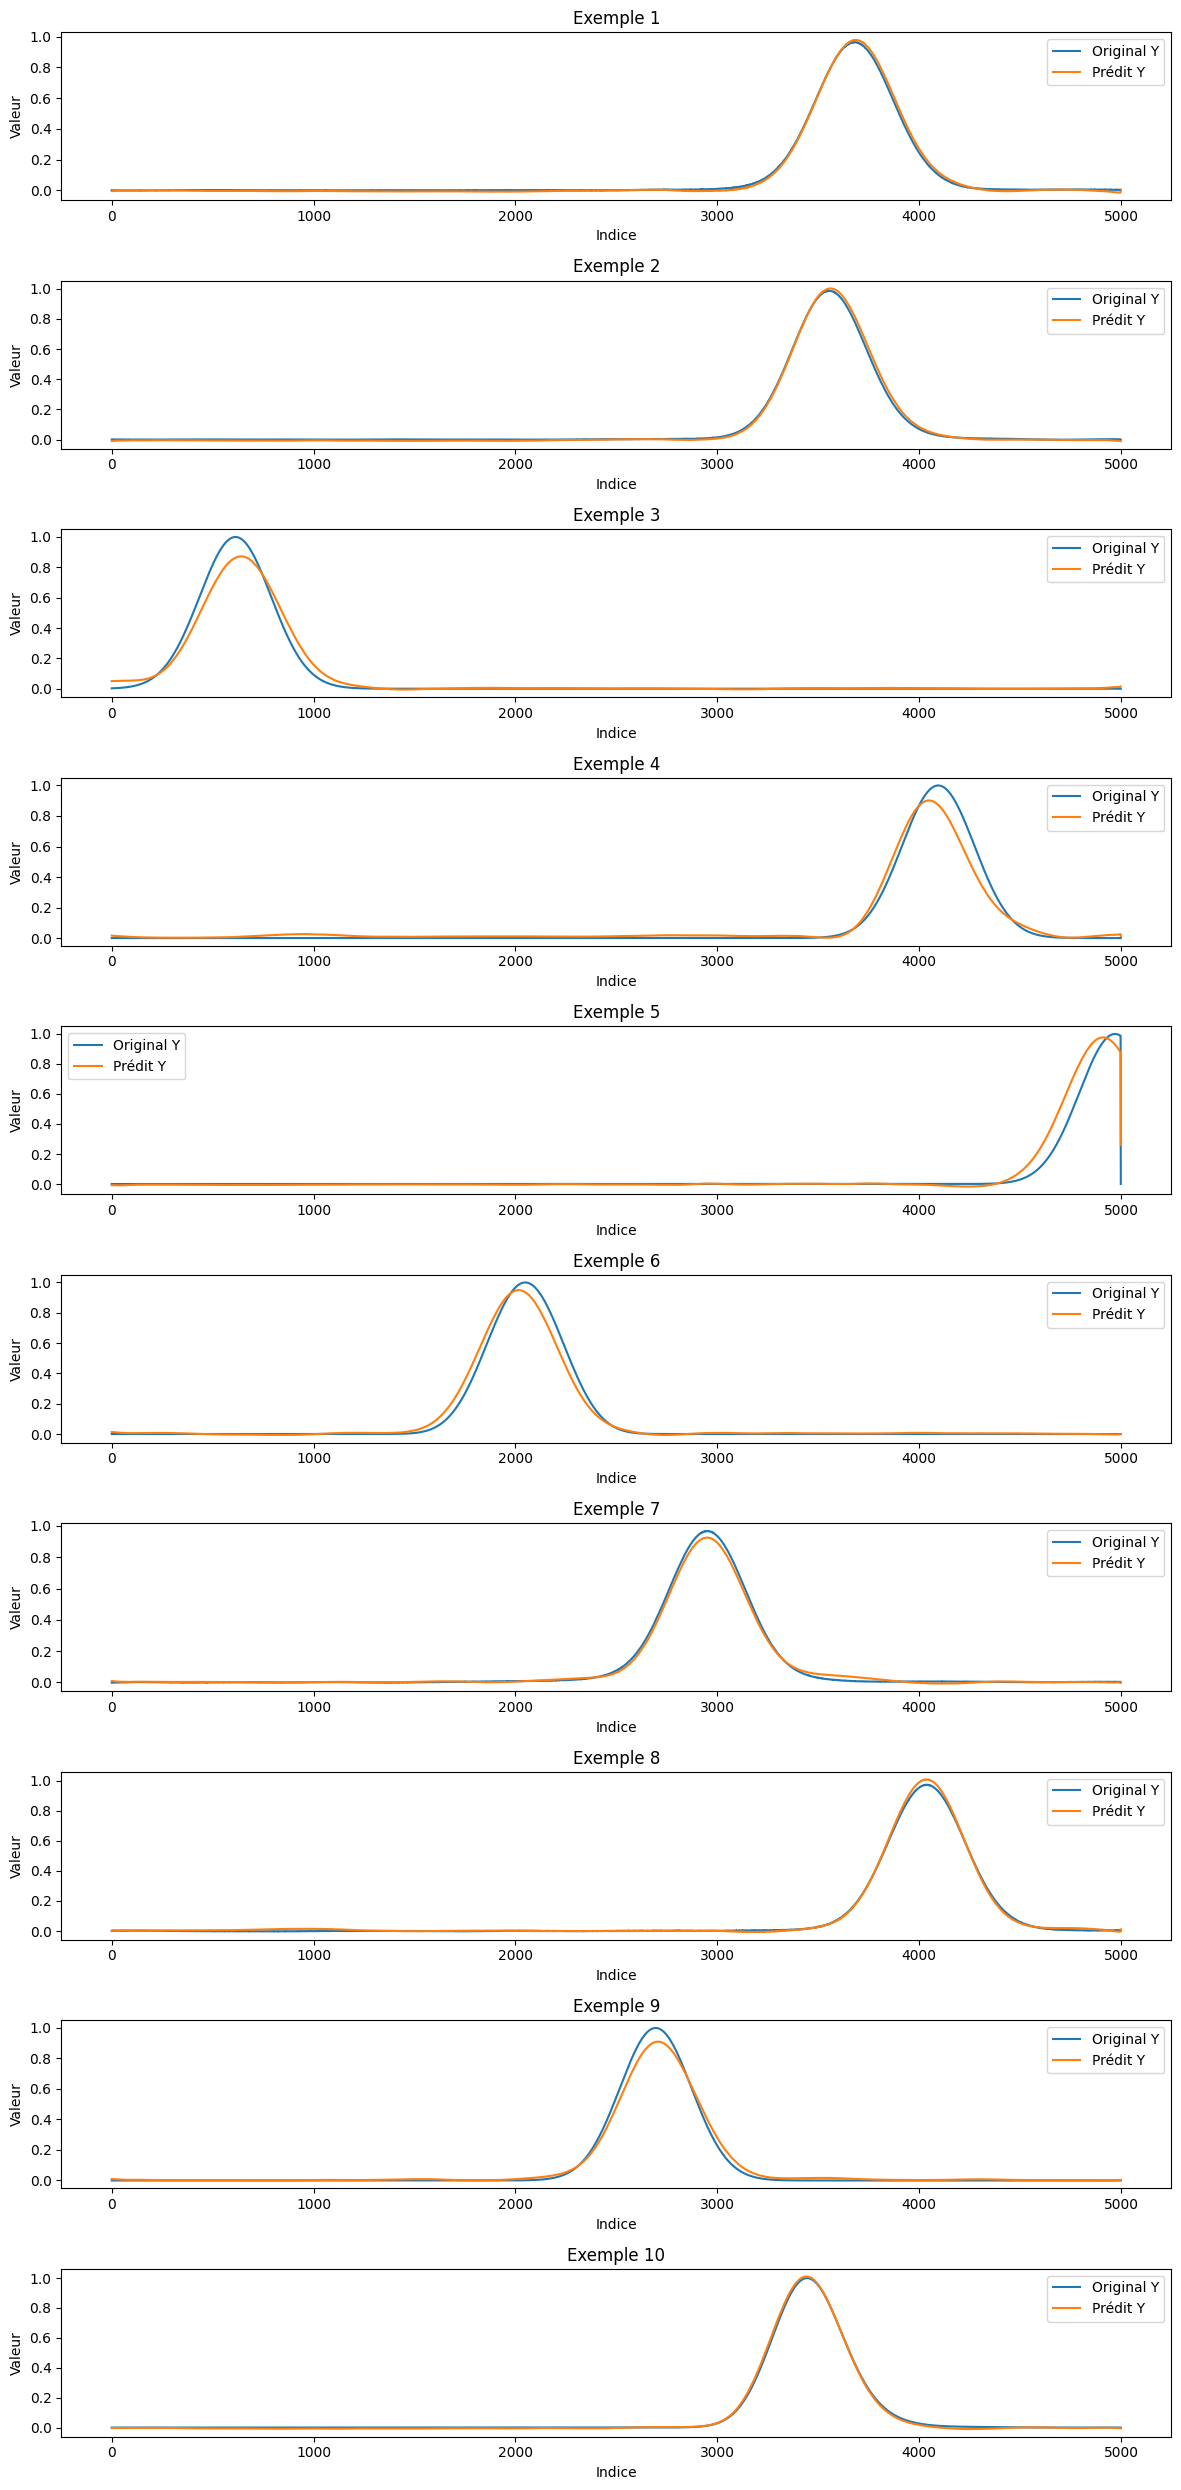

In [133]:
# Mode évaluation et affichage de quelques spectres prédits vs originaux

model.eval()
n_examples = 10  # nombre d'exemples à afficher

with torch.no_grad():
    # On prend un batch de validation
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred_y = model(xb)
        break  # On ne prend que le premier batch

# Conversion en numpy pour affichage
xb_np = xb.cpu().numpy()
yb_np = yb.cpu().numpy()
pred_y_np = pred_y.cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2.5 * n_examples))
for i in range(n_examples):
    plt.subplot(n_examples, 1, i+1)
    plt.plot(yb_np[i], label='Original Y')
    plt.plot(pred_y_np[i], label='Prédit Y')
    plt.title(f"Exemple {i+1}")
    plt.xlabel("Indice")
    plt.ylabel("Valeur")
    plt.legend()
plt.tight_layout()
plt.show()